## Imports

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import lib
import data

## 0. Setup

In [9]:
cameras_params_path = 'data/camera_params/'
images_path = 'data/images/'
cameras_params = data.read_camera_params(cameras_params_path)
cameras = [lib.Camera(cp) for cp in cameras_params]
images = data.read_images(images_path)
index1 = 0
index2 = 1

## 1. 2D points detection and matching

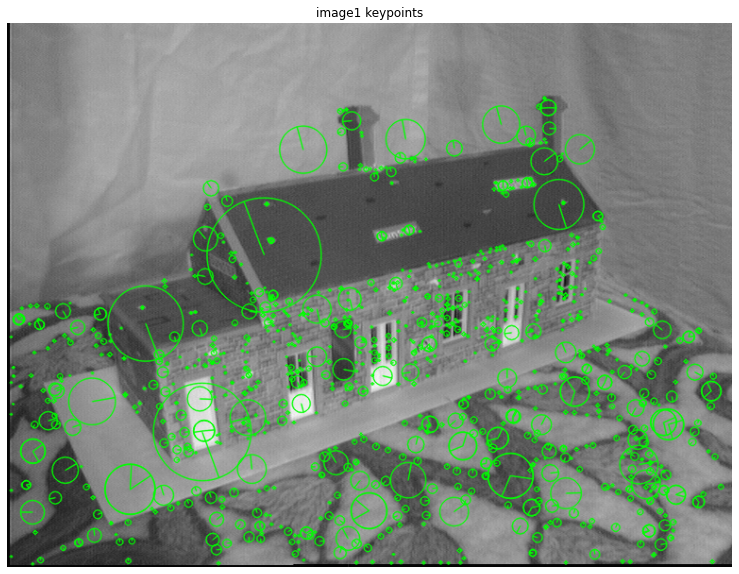

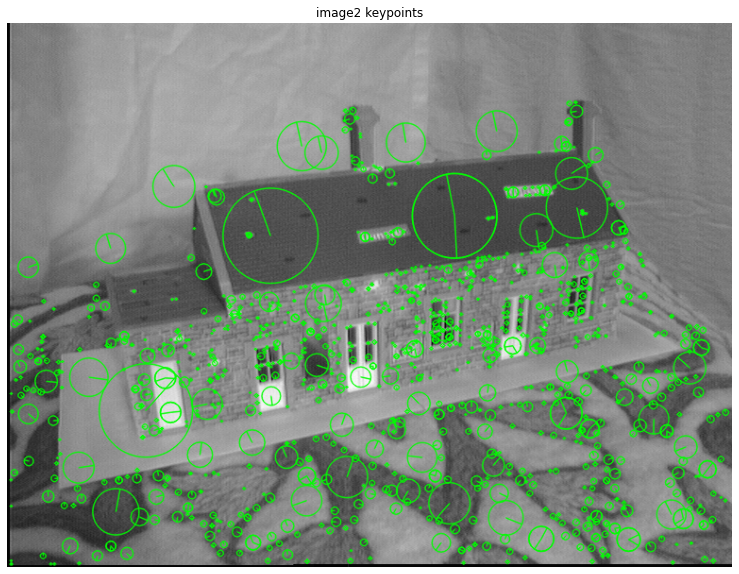

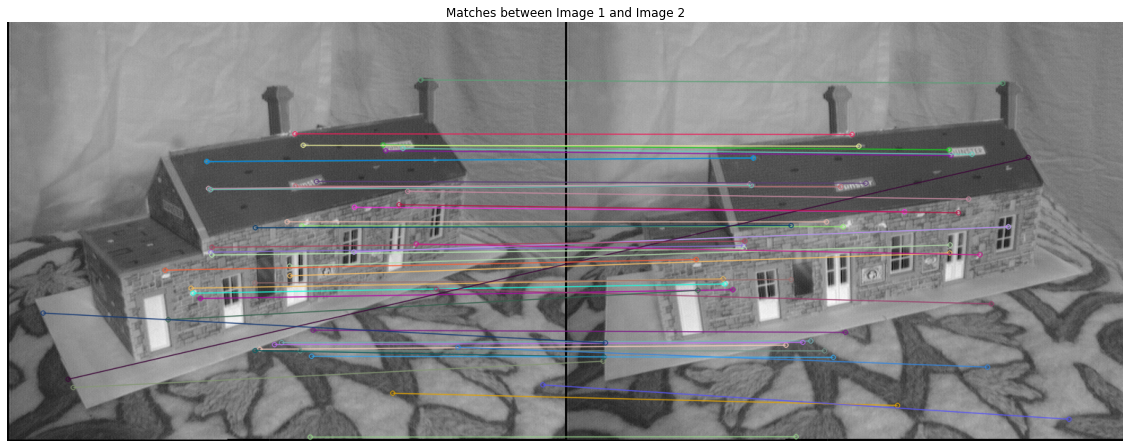

In [10]:
points1, points2 = lib.detect_and_match_keypoints(images[index1], images[index2])

## 3. Triangulacja

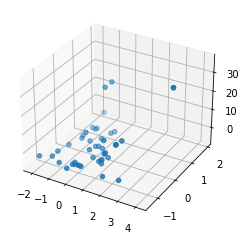

In [12]:
points4D = lib.triangulate_points(cameras[index1], cameras[index2], points1, points2)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points4D[0], points4D[1], points4D[2])
plt.show()

## 4. Dostosowanie wiązki w celu zminimalizowania błędów odwzorowania i dopracowania współrzędnych 3D.

In [ ]:
points2D = np.vstack((points1, points2))
camera_indices = np.hstack((np.zeros(len(points1)), np.ones(len(points2)))).astype(int)
point_indices = np.hstack((np.arange(len(points1)), np.arange(len(points2)))).astype(int)
P = np.array([cameras[index1].getP(), cameras[index2].getP()])

adjusted_points_3d = lib.bundle_adjustment(points4D.T, points2D, camera_indices, point_indices, P)

## 5. Wyznaczenie punktow charaktersyttycznych chmury.

In [ ]:

T, _ = lib.icp(adjusted_points_3d.T, adjusted_points_3d.T)

In [ ]:
normal, mean = pca_base_plane(adjusted_points_3d)